In [2]:
import mltrainer
assert mltrainer.__version__ >= "0.2.5"

In [3]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics
from mltrainer.transformer import print_cpu_memory_usage


In [4]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

In [5]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


Lets test the big dataset

In [6]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Load the data

In [14]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

(Heartdataset (len 87554), Heartdataset (len 21892))

In [94]:
import torch

target_count = 10000
all_indices = []

labels = torch.unique(traindataset.y)
for label in labels:
    class_indices = (traindataset.y == label).nonzero().squeeze()
    if len(class_indices.shape) == 0:
        class_indices = class_indices.unsqueeze(0)  # voor 1 sample

    current_count = len(class_indices)

    if current_count > target_count:
        # Downsampling
        selected = class_indices[torch.randperm(current_count)[:target_count]]
    else:
        # Upsampling
        selected = class_indices[torch.randint(0, current_count, (target_count,))]

    all_indices.append(selected)

# Combineer en shuffle
all_indices = torch.cat(all_indices)
perm = torch.randperm(len(all_indices))
all_indices = all_indices[perm]

# Pas toe op dataset
traindataset.x = traindataset.x[all_indices]
traindataset.y = traindataset.y[all_indices]

# Controleer de nieuwe verdeling
print(f"Nieuwe klassenverdeling: {torch.bincount(traindataset.y)}")


Nieuwe klassenverdeling: tensor([10000, 10000, 10000, 10000, 10000])


Visualise it as 1D data

torch.Size([192, 1]) tensor(0)


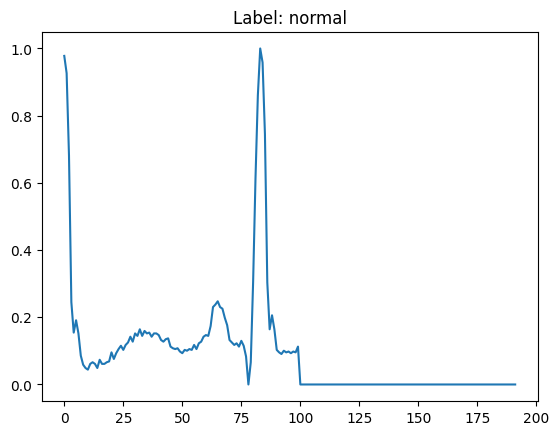

In [17]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

Set up the streamer

In [96]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(1562, 684)

In [97]:
print_cpu_memory_usage()

Current process memory usage: 2279.21 MB


We can import the transformer architecture from `mltrainer`, where i implemented a memory-efficient version of the transformer architecture.

In [98]:
from mltrainer.transformer import Transformer

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its only the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I show how to do that in the `mltrainer.transfomer.forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.
Lets start with a very basic config.

In [99]:
config = {
    "hidden": 16,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 2,
    "num_blocks": 2,
}
model = Transformer(config)

Check if it works

In [100]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

Shapes look good

In [101]:
yhat = model(x)
yhat.shape

torch.Size([32, 5])

Lets test the metrics for the untrained model

In [102]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()
metrics_list = [f1micro, f1macro, precision, recall, accuracy]

In [103]:
for metric in metrics_list:
    print(f"{metric}:", metric(y, yhat))

F1Score_micro: 0.21875
F1Score_macro: 0.07179487179487179
Precision_micro: 0.21875
Recall_macro: 0.2
Accuracy: 0.21875


And the memory

In [104]:
print_cpu_memory_usage()

Current process memory usage: 2279.21 MB


In [105]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam_1d.db")
mlflow.set_experiment("Transformer")

<Experiment: artifact_location='/home/azureuser/MADS-exam-25/notebooks_adriaan/mlruns/1', creation_time=1750250493190, experiment_id='1', last_update_time=1750250493190, lifecycle_stage='active', name='Transformer', tags={}>

We want to have feedback more often, so lets test metrics every 1/5th of the dataset

In [106]:
steps = len(trainstreamer) // 5
steps

312

In [107]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=steps,
        valid_steps=steps,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        device=device,
        )
    trainer.loop()

2025-06-18 13:10:31.494 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart1D/20250618-131031
100%|██████████| 312/312 [00:15<00:00, 19.97it/s]
2025-06-18 13:10:51.481 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.4106 test 1.5495 metric ['0.2542', '0.2542', '0.1742', '0.2542', '0.3969']
100%|██████████| 312/312 [00:15<00:00, 20.24it/s]
2025-06-18 13:11:11.490 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 1.2375 test 1.5920 metric ['0.2582', '0.2582', '0.1881', '0.2582', '0.4243']
100%|██████████| 312/312 [00:15<00:00, 20.21it/s]
2025-06-18 13:11:31.273 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 1.1317 test 1.5005 metric ['0.3043', '0.3043', '0.2177', '0.3043', '0.4778']
100%|██████████| 312/312 [00:15<00:00, 20.08it/s]
2025-06-18 13:11:51.126 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 1.0417 test 1.5299 metric ['0.3662', '0.3662', '0.2668', '0.3662', '0.5778']
100%|██████████| 312/312 [00:15<00:00, 20.14it

In [108]:
print_cpu_memory_usage()

Current process memory usage: 2281.47 MB


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

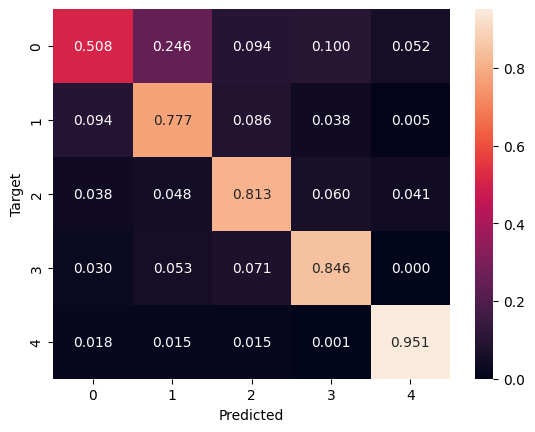

In [109]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
model.to("cpu")
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")